In [35]:
import networkx as nx
import random
from networkx.algorithms import approximation as approx
import matplotlib.pyplot as plt

# Graph creation

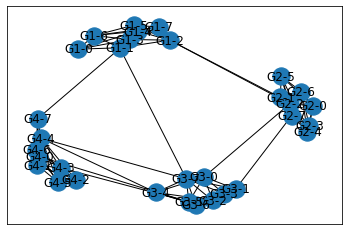

In [69]:
G = nx.union(nx.union(nx.erdos_renyi_graph(8, 0.85), nx.erdos_renyi_graph(8, 0.85), rename=('G1-', 'G2-')), nx.union(nx.erdos_renyi_graph(8, 0.85), nx.erdos_renyi_graph(8, 0.85), rename=('G3-', 'G4-')))

nodes = list(G.nodes())

count = 0
while count < 10:
  i = random.randint(0, len(nodes)-1)
  j = random.randint(0, len(nodes)-1)

  if i != j and not (nodes[i], nodes[j]) in G.edges:
    G.add_edge(nodes[i], nodes[j])
    count += 1

# adding random weight to edges:
for e in G.edges:
  G[e[0]][e[1]]['weight'] = random.random()
  if e[0][:2] != e[1][:2]:
    G[e[0]][e[1]]['weight'] += 1
    G[e[0]][e[1]]['weight'] *= 100

  G[e[0]][e[1]]['inverse_weight'] = 1/G[e[0]][e[1]]['weight']

total_pos = nx.spring_layout(G, pos=nx.spectral_layout(G), weight='inverse_weight', k=2)

nx.draw_networkx(G, pos=total_pos)

# Direct TSP approach
### Non-realistic comparison

Cycle cost: 699.5545045217984


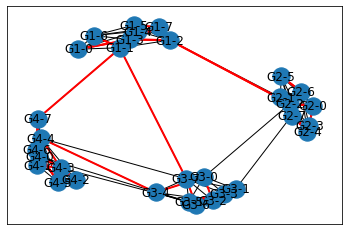

In [70]:
cycle = approx.traveling_salesman_problem(G)

_ = nx.draw_networkx(G, total_pos)
path_edges = list(zip(cycle,cycle[1:]))
_ = nx.draw_networkx_edges(G,total_pos,edgelist=path_edges,edge_color='r', width=2)

cost = sum(G[n][nbr]["weight"] for n, nbr in nx.utils.pairwise(cycle))
print('Cycle cost:', cost)

# Clustering approach
### With bi-partition

In [71]:
(l1, l2) = nx.community.kernighan_lin_bisection(G, weight='inverse_weights')
l1 = list(l1)
l2 = list(l2)

G_aux1 = G.subgraph(l1)
G_aux2 = G.subgraph(l2)

(l11, l12) = nx.community.kernighan_lin_bisection(G_aux1, weight='inverse_weights')
(l21, l22) = nx.community.kernighan_lin_bisection(G_aux2, weight='inverse_weights')

G_list = [G.subgraph(l11), G.subgraph(l12), G.subgraph(l21), G.subgraph(l22)]

Cycle cost: 2.0085762425284925 ['G3-0', 'G3-4', 'G3-0', 'G3-2', 'G3-3', 'G3-5', 'G3-1', 'G3-6', 'G3-7', 'G3-0']
Cycle cost: 2.9156060073246457 ['G4-6', 'G4-5', 'G4-4', 'G4-3', 'G4-0', 'G4-3', 'G4-2', 'G4-3', 'G4-1', 'G4-7', 'G4-1', 'G4-6']
Cycle cost: 2.4134925717769713 ['G2-5', 'G2-6', 'G2-2', 'G2-1', 'G2-4', 'G2-1', 'G2-2', 'G2-0', 'G2-3', 'G2-0', 'G2-2', 'G2-7', 'G2-6', 'G2-5']
Cycle cost: 1.9777070975748516 ['G1-4', 'G1-5', 'G1-7', 'G1-3', 'G1-2', 'G1-3', 'G1-0', 'G1-3', 'G1-6', 'G1-1', 'G1-5', 'G1-4']


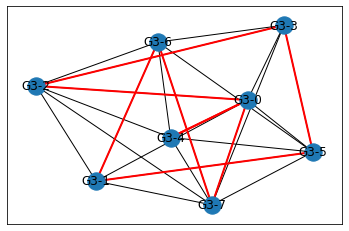

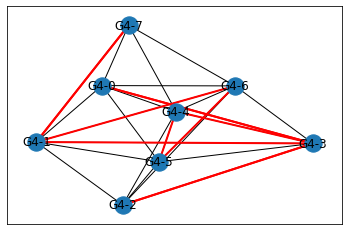

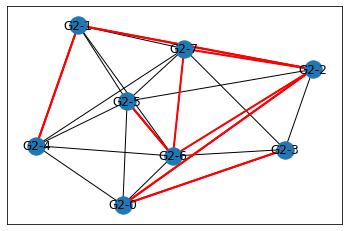

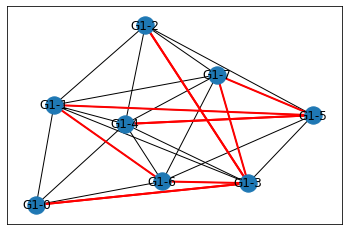

In [72]:
cycles = []
for i,G_aux in enumerate(G_list):
  plt.figure(i)
  pos = nx.spring_layout(G_aux, pos=nx.spectral_layout(G_aux))
  cycle = approx.traveling_salesman_problem(G_aux)
  cycles.append(cycle)

  _ = nx.draw_networkx(G_aux, pos)
  path_edges = list(zip(cycle,cycle[1:]))
  _ = nx.draw_networkx_edges(G_aux,pos,edgelist=path_edges,edge_color='r', width=2)

  cost = sum(G[n][nbr]["weight"] for n, nbr in nx.utils.pairwise(cycle))
  print('Cycle cost:', cost, cycle)


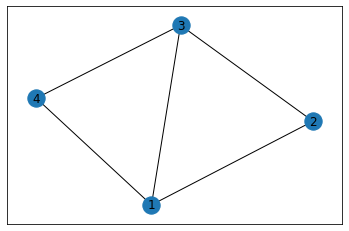

In [73]:
# Construction of the inter-city graph
G_city = nx.Graph()
G_city.add_nodes_from([1, 2, 3, 4])

# edges
edges_to_add = {}
for e in G.edges:
  if e[0][:2] != e[1][:2]:
    if not (int(e[0][1:2]), int(e[1][1:2])) in edges_to_add or edges_to_add[(int(e[0][1:2]), int(e[1][1:2]))]['weight'] > G.get_edge_data(e[0], e[1])['weight']:
      edges_to_add[(int(e[0][1:2]), int(e[1][1:2]))] = {'weight': G.get_edge_data(e[0], e[1])['weight'], 'nodes': e}

for k in edges_to_add:
  nodes = list(G_city.nodes())
  G_city.add_edge(*k)
  G_city[k[0]][k[1]]['weight'] = edges_to_add[k]['weight']

pos = nx.spring_layout(G_city, pos=nx.spectral_layout(G_city))
nx.draw_networkx(G_city, pos=pos)

Cycle cost: 690.8018128888423


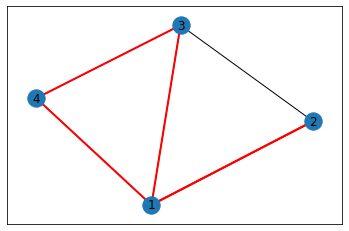

In [74]:
# TSP in the global graph
cycle = approx.traveling_salesman_problem(G_city)

_ = nx.draw_networkx(G_city, pos)
path_edges = list(zip(cycle,cycle[1:]))
_ = nx.draw_networkx_edges(G_city,pos,edgelist=path_edges,edge_color='r', width=2)

cost = sum(G_city[n][nbr]["weight"] for n, nbr in nx.utils.pairwise(cycle))
print('Cycle cost:', cost)


### Reconstruction of the total cycle

In [75]:
def find_city(G_list, node):
  for i,G in enumerate(G_list):
    if node in list(G.nodes()):
      return i
  return -1

In [76]:
def shift(seq, n):
  return seq[n:]+seq[:n]

In [77]:
def find_neighbours(cycle, node):
  # print(node, cycle)
  index = cycle.index(node)
  n1 = cycle[index-1]
  n2 = cycle[index+1] if index+1 < len(cycle) else cycle[0]

  return n1, n2

In [78]:
def cycle_to_path_cost(G, neighbour, comm_node_1, comm_node_2):
  if (neighbour, comm_node_1) in G.edges():
    return nx.dijkstra_path_length(G, comm_node_2, neighbour) - G[neighbour][comm_node_1]['weight']
  else:
    return nx.dijkstra_path_length(G, comm_node_2, neighbour) - G[comm_node_1][neighbour]['weight']

In [79]:
cycle_edges = []

for i in range(len(cycle)-1):
  src_node = min([cycle[i], cycle[i+1]])
  dst_node = max([cycle[i], cycle[i+1]])
  cycle_edges.append(edges_to_add[(src_node, dst_node)]['nodes'])
  if cycle[i] > cycle[i+1]:
    cycle_edges[-1] = cycle_edges[-1][::-1]

In [80]:
hyper_connected_nodes = []

for i in range(len(cycle_edges)-1):
  hyper_connected_nodes.append([cycle_edges[i][1], cycle_edges[i+1][0]])

hyper_connected_nodes.append([cycle_edges[-1][1], cycle_edges[0][0]])

In [81]:
final_cycle = []

for city_nodes in hyper_connected_nodes:
  final_cycle.append(city_nodes[0])
  aux_cost = []
  city_index = find_city(G_list, city_nodes[0])

  neighbours_1 = (find_neighbours(cycles[city_index], city_nodes[0]))
  neighbours_2 = (find_neighbours(cycles[city_index], city_nodes[1]))

  for n in neighbours_1:
    aux_cost.append([cycle_to_path_cost(G, n, city_nodes[0], city_nodes[1]), n, city_nodes[0]])
  
  for n in neighbours_2:
    aux_cost.append([cycle_to_path_cost(G, n, city_nodes[1], city_nodes[0]), n, city_nodes[1]])

  aux_cost.sort()
  if aux_cost[0][2] == city_nodes[0]:
    final_cycle += shift(cycles[city_index], cycles[city_index].index(city_nodes[0]))[1:] + nx.dijkstra_path(G, aux_cost[0][1], city_nodes[1])[1:-1]
  else:
    final_cycle += nx.dijkstra_path(G, city_nodes[0], aux_cost[0][1]) + shift(cycles[city_index], cycles[city_index].index(city_nodes[1]))[::-1][1:-1]
  final_cycle.append(city_nodes[1])
final_cycle.append(final_cycle[0])


In [82]:
i = 0
while i < len(final_cycle)-1:
    if final_cycle[i] == final_cycle[i+1]:
      del(final_cycle[i+1])
    else:
      i += 1

Cycle cost: 702.2381899213364


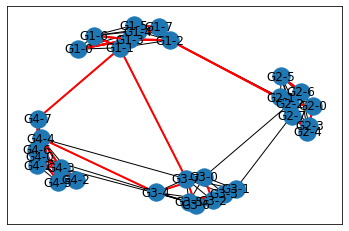

In [84]:
_ = nx.draw_networkx(G, total_pos)
path_edges = list(zip(final_cycle, final_cycle[1:]))
_ = nx.draw_networkx_edges(G, total_pos, edgelist=path_edges, edge_color='r', width=2)

cost = sum(G[n][nbr]["weight"] if (n,nbr) in G.edges else 0 for n, nbr in nx.utils.pairwise(final_cycle))
print('Cycle cost:', cost)